In [1]:
# python
from tqdm.notebook import tqdm
import sys
import os
import importlib
# columnar analysis
import awkward as ak
import mplhep as hep
import numpy as np
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
# local
sys.path.insert(1, os.path.join(sys.path[0], '../..')) # fixme: there must be a better way to handle this...
from sidm.tools import sidm_processor, utilities
# always reload local modules to pick up changes during development
importlib.reload(sidm_processor)
importlib.reload(utilities)
# plotting
import matplotlib.pyplot as plt
utilities.set_plot_style()
%matplotlib inline

In [2]:
def structure(vari, cha1, cha2):
    print("4mu {0} structure: {1}".format(vari, cha1))
    print("2mu2e {0} structure: {1}".format(vari, cha2))
    
    return vari

In [3]:
samples_2mu2e = [
    '2mu2e_500GeV_5GeV_0p08mm',
    '2mu2e_500GeV_5GeV_0p8mm',
    '2mu2e_500GeV_5GeV_8p0mm',
    '2mu2e_500GeV_5GeV_40p0mm',
    '2mu2e_500GeV_5GeV_80p0mm',
]

samples_4mu = [
    '4mu_500GeV_5GeV_0p08mm',
    '4mu_500GeV_5GeV_0p8mm',
    '4mu_500GeV_5GeV_8p0mm',
    '4mu_500GeV_5GeV_40p0mm',
    '4mu_500GeV_5GeV_80p0mm',
]

In [4]:
fileset_4mu = utilities.make_fileset(samples_4mu, "llpNanoAOD_v2_merged")
fileset_2mu2e = utilities.make_fileset(samples_2mu2e, "llpNanoAOD_v2_merged")

events_2mu2e, events_4mu = {}, {}

for i in tqdm(samples_2mu2e):
    fname = fileset_2mu2e[i][0]
    print(fname)
    events_2mu2e[i] = NanoEventsFactory.from_root(
        fname,
        schemaclass=NanoAODSchema,
    ).events().TrigObj
    
for i in tqdm(samples_4mu):
    fname = fileset_4mu[i][0]
    print(fname)
    events_4mu[i] = NanoEventsFactory.from_root(
        fname,
        schemaclass=NanoAODSchema,
    ).events().TrigObj

  0%|          | 0/5 [00:00<?, ?it/s]

root://xcache//store/user/dlee3/V2/SIDM_BsTo1DpTo2Mu2e_MBs-500_MDp-5p0_ctau-0p08.root
root://xcache//store/user/dlee3/V2/SIDM_BsTo2DpTo2Mu2e_MBs-500_MDp-5p0_ctau-0p8.root
root://xcache//store/user/dlee3/V2/SIDM_BsTo2DpTo2Mu2e_MBs-500_MDp-5p0_ctau-8p0.root
root://xcache//store/user/dlee3/V2/SIDM_BsTo2DpTo2Mu2e_MBs-500_MDp-5p0_ctau-40p0.root
root://xcache//store/user/dlee3/V2/SIDM_BsTo2DpTo2Mu2e_MBs-500_MDp-5p0_ctau-80p0.root


  0%|          | 0/5 [00:00<?, ?it/s]

root://xcache//store/user/dlee3/V2/SIDM_BsTo2DpTo4Mu_MBs-500_MDp-5p0_ctau-0p08.root
root://xcache//store/user/dlee3/V2/SIDM_BsTo2DpTo4Mu_MBs-500_MDp-5p0_ctau-0p8.root
root://xcache//store/user/dlee3/V2/SIDM_BsTo2DpTo4Mu_MBs-500_MDp-5p0_ctau-8p0.root
root://xcache//store/user/dlee3/V2/SIDM_BsTo2DpTo4Mu_MBs-500_MDp-5p0_ctau-40p0.root
root://xcache//store/user/dlee3/V2/SIDM_BsTo2DpTo4Mu_MBs-500_MDp-5p0_ctau-80p0.root


In [5]:
import heapq

In [6]:
def mask(obj):
    
    sel = ak.num(obj) > 1
    masked_obj = obj[sel]
    
    return masked_obj

In [7]:
def mask_4mu(obj):
    
    sel = ak.num(obj) > 3
    masked_obj = obj[sel]
    
    return masked_obj

In [8]:
def selection(cha, i):
    
    jet = cha[i][cha[i].id == 1]
    ele = cha[i][cha[i].id == 11]
    mu = cha[i][cha[i].id == 13]
    ta = cha[i][cha[i].id == 15]
    
    sel_jet, sel_ele, sel_mu, sel_ta = mask(jet), mask(ele), mask(mu), mask(ta)
    
    return sel_jet, sel_ele, sel_mu, sel_ta

In [9]:
def selection_4mu(cha, i):
    
    jet = cha[i][cha[i].id == 1]
    ele = cha[i][cha[i].id == 11]
    mu = cha[i][cha[i].id == 13]
    ta = cha[i][cha[i].id == 15]
    
    sel_jet, sel_ele, sel_mu, sel_ta = mask_4mu(jet), mask_4mu(ele), mask_4mu(mu), mask_4mu(ta)
    
    return sel_jet, sel_ele, sel_mu, sel_ta

In [10]:
def sorting(data):
    
    leading_obj, subleading_obj = {}, {}
    
    for i in tqdm(range(len(data))):
        
        leading_pt = [heapq.nlargest(2, data['pt'][i])[0]]    
        subleading_pt = [heapq.nlargest(2, data['pt'][i])[1]]
        
        if len(leading_obj) == 0:
            leading_obj['pt'] = leading_pt
            subleading_obj['pt'] = subleading_pt
            
        else:
            leading_obj['pt'] = np.concatenate([leading_obj['pt'], leading_pt])
            subleading_obj['pt'] = np.concatenate([subleading_obj['pt'], subleading_pt])
        
    return leading_obj, subleading_obj

In [11]:
def sorting_4mu(data):
    
    leading_obj, subleading_obj, third_obj, fourth_obj = {}, {}, {}, {}
    
    for i in tqdm(range(len(data))):
        
        leading_pt = [heapq.nlargest(4, data['pt'][i])[0]]    
        subleading_pt = [heapq.nlargest(4, data['pt'][i])[1]]
        third_pt = [heapq.nlargest(4, data['pt'][i])[2]]    
        fourth_pt = [heapq.nlargest(4, data['pt'][i])[3]]
        
        if len(leading_obj) == 0:
            leading_obj['pt'] = leading_pt
            subleading_obj['pt'] = subleading_pt
            third_obj['pt'] = third_pt
            fourth_obj['pt'] = fourth_pt
            
        else:
            leading_obj['pt'] = np.concatenate([leading_obj['pt'], leading_pt])
            subleading_obj['pt'] = np.concatenate([subleading_obj['pt'], subleading_pt])
            third_obj['pt'] = np.concatenate([third_obj['pt'], third_pt])
            fourth_obj['pt'] = np.concatenate([fourth_obj['pt'], fourth_pt])
        
    return leading_obj, subleading_obj, third_obj, fourth_obj

In [12]:
def plotting(v1,v2,v3,v4,v5,v6,v7,v8,i,j,r1,r2):

    ax[i][j].hist(v1, range=(r1,r2), alpha=1, bins=100, histtype='step', linewidth=3, label='Leading_Jet')
    ax[i][j].hist(v2, range=(r1,r2), alpha=1, bins=100, histtype='step', linewidth=3, label='Leading_Electron')
    ax[i][j].hist(v3, range=(r1,r2), alpha=1, bins=100, histtype='step', linewidth=3, label='Leading_Muon')
    ax[i][j].hist(v4, range=(r1,r2), alpha=1, bins=100, histtype='step', linewidth=3, label='Leading_Tau')
    ax[i][j].hist(v5, range=(r1,r2), alpha=1, bins=100, histtype='step', linewidth=3, linestyle='dashed', label='Sub-leading_Jet')
    ax[i][j].hist(v6, range=(r1,r2), alpha=1, bins=100, histtype='step', linewidth=3, linestyle='dashed',label='Sub-leading_Electron')
    ax[i][j].hist(v7, range=(r1,r2), alpha=1, bins=100, histtype='step', linewidth=3, linestyle='dashed',label='Subleading_Muon') 
    ax[i][j].hist(v8, range=(r1,r2), alpha=1, bins=100, histtype='step', linewidth=3, linestyle='dashed',label='Sub-leading_Tau')
    
    ax[i][j].set_xlim(r1,r2)
    ax[i][j].set_ylabel('Counts')
    ax[i][j].set_yscale("log")
    ax[i][j].legend(fontsize=20)

In [13]:
def label(vari):
    ax[0][0].set_xlabel('{0}'.format(vari))
    ax[0][1].set_xlabel('{0}'.format(vari))
    ax[1][0].set_xlabel('{0}'.format(vari))
    ax[1][1].set_xlabel('{0}'.format(vari))
    ax[2][0].set_xlabel('{0}'.format(vari))
    ax[2][1].set_xlabel('{0}'.format(vari))
    ax[3][0].set_xlabel('{0}'.format(vari))
    ax[3][1].set_xlabel('{0}'.format(vari))
    ax[4][0].set_xlabel('{0}'.format(vari))
    ax[4][1].set_xlabel('{0}'.format(vari))   
    
    ax[0][0].set_title('4mu_500GeV_5GeV_0p08mm',color='r')
    ax[0][1].set_title('2mu2e_500GeV_5GeV_0p08mm',color='b')
    ax[1][0].set_title('4mu_500GeV_5GeV_0p8mm',color='r')
    ax[1][1].set_title('2mu2e_500GeV_5GeV_0p8mm',color='b')
    ax[2][0].set_title('4mu_500GeV_5GeV_8p0mm',color='r')
    ax[2][1].set_title('2mu2e_500GeV_5GeV_8p0mm',color='b')
    ax[3][0].set_title('4mu_500GeV_5GeV_40p0mm',color='r')
    ax[3][1].set_title('2mu2e_500GeV_5GeV_40p0mm',color='b')
    ax[4][0].set_title('4mu_500GeV_5GeV_80p0mm',color='r')
    ax[4][1].set_title('2mu2e_500GeV_5GeV_80p0mm',color='b')   

In [14]:
fmu1_jet, fmu1_ele, fmu1_mu, fmu1_ta = selection(events_4mu, "4mu_500GeV_5GeV_0p08mm")
fmu2_jet, fmu2_ele, fmu2_mu, fmu2_ta = selection(events_4mu, "4mu_500GeV_5GeV_0p8mm")
fmu3_jet, fmu3_ele, fmu3_mu, fmu3_ta = selection(events_4mu, "4mu_500GeV_5GeV_8p0mm")
fmu4_jet, fmu4_ele, fmu4_mu, fmu4_ta = selection(events_4mu, "4mu_500GeV_5GeV_40p0mm")
fmu5_jet, fmu5_ele, fmu5_mu, fmu5_ta = selection(events_4mu, "4mu_500GeV_5GeV_80p0mm")

tmu1_jet, tmu1_ele, tmu1_mu, tmu1_ta = selection(events_2mu2e, "2mu2e_500GeV_5GeV_0p08mm")
tmu2_jet, tmu2_ele, tmu2_mu, tmu2_ta = selection(events_2mu2e, "2mu2e_500GeV_5GeV_0p8mm")
tmu3_jet, tmu3_ele, tmu3_mu, tmu3_ta = selection(events_2mu2e, "2mu2e_500GeV_5GeV_8p0mm")
tmu4_jet, tmu4_ele, tmu4_mu, tmu4_ta = selection(events_2mu2e, "2mu2e_500GeV_5GeV_40p0mm")
tmu5_jet, tmu5_ele, tmu5_mu, tmu5_ta = selection(events_2mu2e, "2mu2e_500GeV_5GeV_80p0mm")

In [15]:
l_fmu1_jet, sl_fmu1_jet = sorting(fmu1_jet)
l_fmu1_ele, sl_fmu1_ele= sorting(fmu1_ele)
l_fmu1_mu, sl_fmu1_mu = sorting(fmu1_mu)
l_fmu1_ta, sl_fmu1_ta = sorting(fmu1_ta)

l_tmu1_jet, sl_tmu1_jet = sorting(tmu1_jet)
l_tmu1_ele, sl_tmu1_ele= sorting(tmu1_ele)
l_tmu1_mu, sl_tmu1_mu = sorting(tmu1_mu)
l_tmu1_ta, sl_tmu1_ta = sorting(tmu1_ta)

  0%|          | 0/2565 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/114128 [00:00<?, ?it/s]

  0%|          | 0/86983 [00:00<?, ?it/s]

  0%|          | 0/39823 [00:00<?, ?it/s]

  0%|          | 0/27153 [00:00<?, ?it/s]

  0%|          | 0/93292 [00:00<?, ?it/s]

  0%|          | 0/79899 [00:00<?, ?it/s]

In [ ]:
l_fmu2_jet, sl_fmu2_jet = sorting(fmu2_jet)
l_fmu2_ele, sl_fmu2_ele= sorting(fmu2_ele)
l_fmu2_mu, sl_fmu2_mu = sorting(fmu2_mu)
l_fmu2_ta, sl_fmu2_ta = sorting(fmu2_ta)

l_tmu2_jet, sl_tmu2_jet = sorting(tmu2_jet)
l_tmu2_ele, sl_tmu2_ele= sorting(tmu2_ele)
l_tmu2_mu, sl_tmu2_mu = sorting(tmu2_mu)
l_tmu2_ta, sl_tmu2_ta = sorting(tmu2_ta)

  0%|          | 0/2653 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/118876 [00:00<?, ?it/s]

  0%|          | 0/94772 [00:00<?, ?it/s]

  0%|          | 0/27464 [00:00<?, ?it/s]

  0%|          | 0/10909 [00:00<?, ?it/s]

  0%|          | 0/62127 [00:00<?, ?it/s]

  0%|          | 0/51223 [00:00<?, ?it/s]

In [17]:
l_fmu3_jet, sl_fmu3_jet = sorting(fmu3_jet)
l_fmu3_ele, sl_fmu3_ele= sorting(fmu3_ele)
l_fmu3_mu, sl_fmu3_mu = sorting(fmu3_mu)
l_fmu3_ta, sl_fmu3_ta = sorting(fmu3_ta)

l_tmu3_jet, sl_tmu3_jet = sorting(tmu2_jet)
l_tmu3_ele, sl_tmu3_ele= sorting(tmu2_ele)
l_tmu3_mu, sl_tmu3_mu = sorting(tmu2_mu)
l_tmu3_ta, sl_tmu3_ta = sorting(tmu2_ta)

  0%|          | 0/2928 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/82546 [00:00<?, ?it/s]

  0%|          | 0/39814 [00:00<?, ?it/s]

  0%|          | 0/27464 [00:00<?, ?it/s]

  0%|          | 0/10909 [00:00<?, ?it/s]

  0%|          | 0/62127 [00:00<?, ?it/s]

  0%|          | 0/51223 [00:00<?, ?it/s]

In [18]:
l_fmu4_jet, sl_fmu4_jet = sorting(fmu4_jet)
l_fmu4_ele, sl_fmu4_ele= sorting(fmu4_ele)
l_fmu4_mu, sl_fmu4_mu = sorting(fmu4_mu)
l_fmu4_ta, sl_fmu4_ta = sorting(fmu4_ta)

l_tmu4_jet, sl_tmu4_jet = sorting(tmu4_jet)
l_tmu4_ele, sl_tmu4_ele= sorting(tmu4_ele)
l_tmu4_mu, sl_tmu4_mu = sorting(tmu4_mu)
l_tmu4_ta, sl_tmu4_ta = sorting(tmu4_ta)

  0%|          | 0/2587 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/23490 [00:00<?, ?it/s]

  0%|          | 0/8731 [00:00<?, ?it/s]

  0%|          | 0/18671 [00:00<?, ?it/s]

  0%|          | 0/499 [00:00<?, ?it/s]

  0%|          | 0/5777 [00:00<?, ?it/s]

  0%|          | 0/2969 [00:00<?, ?it/s]

In [19]:
l_fmu5_jet, sl_fmu5_jet = sorting(fmu5_jet)
l_fmu5_ele, sl_fmu5_ele= sorting(fmu5_ele)
l_fmu5_mu, sl_fmu5_mu = sorting(fmu5_mu)
l_fmu5_ta, sl_fmu5_ta = sorting(fmu5_ta)

l_tmu5_jet, sl_tmu5_jet = sorting(tmu5_jet)
l_tmu5_ele, sl_tmu5_ele= sorting(tmu5_ele)
l_tmu5_mu, sl_tmu5_mu = sorting(tmu5_mu)
l_tmu5_ta, sl_tmu5_ta = sorting(tmu5_ta)

  0%|          | 0/1911 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

  0%|          | 0/11272 [00:00<?, ?it/s]

  0%|          | 0/3701 [00:00<?, ?it/s]

  0%|          | 0/18939 [00:00<?, ?it/s]

  0%|          | 0/377 [00:00<?, ?it/s]

  0%|          | 0/4528 [00:00<?, ?it/s]

  0%|          | 0/2330 [00:00<?, ?it/s]

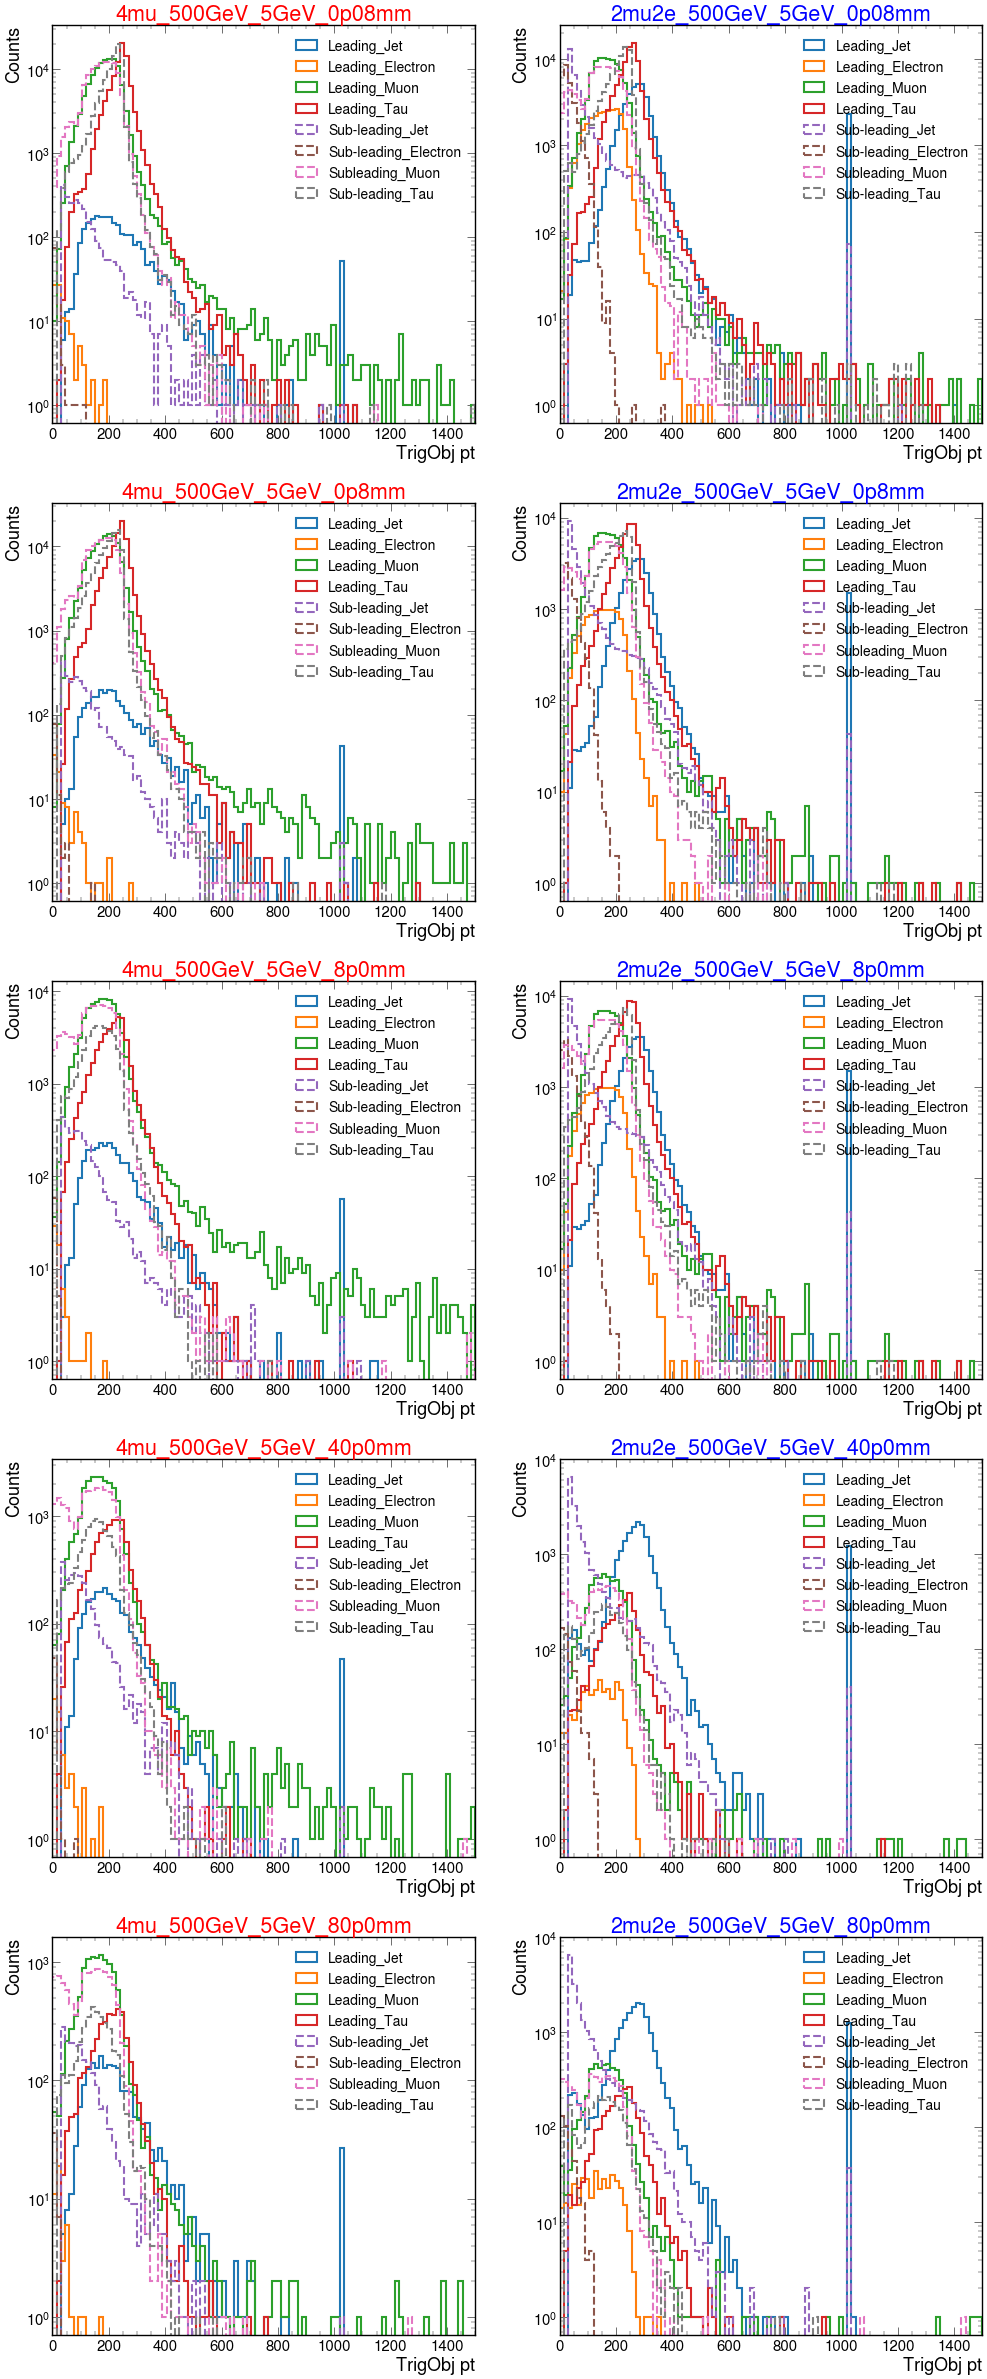

In [20]:
plt.style.use(hep.style.CMS)
fig, ax = plt.subplots(5, 2, figsize=(24,60))

plotting(l_fmu1_jet['pt'], l_fmu1_ele['pt'], l_fmu1_mu['pt'], l_fmu1_ta['pt'], sl_fmu1_jet['pt'], sl_fmu1_ele['pt'], sl_fmu1_mu['pt'], sl_fmu1_ta['pt'], 0, 0, 0, 1500)
plotting(l_tmu1_jet['pt'], l_tmu1_ele['pt'], l_tmu1_mu['pt'], l_tmu1_ta['pt'], sl_tmu1_jet['pt'], sl_tmu1_ele['pt'], sl_tmu1_mu['pt'], sl_tmu1_ta['pt'], 0, 1, 0, 1500)

plotting(l_fmu2_jet['pt'], l_fmu2_ele['pt'], l_fmu2_mu['pt'], l_fmu2_ta['pt'], sl_fmu2_jet['pt'], sl_fmu2_ele['pt'], sl_fmu2_mu['pt'], sl_fmu2_ta['pt'], 1, 0, 0, 1500)
plotting(l_tmu2_jet['pt'], l_tmu2_ele['pt'], l_tmu2_mu['pt'], l_tmu2_ta['pt'], sl_tmu2_jet['pt'], sl_tmu2_ele['pt'], sl_tmu2_mu['pt'], sl_tmu2_ta['pt'], 1, 1, 0, 1500)

plotting(l_fmu3_jet['pt'], l_fmu3_ele['pt'], l_fmu3_mu['pt'], l_fmu3_ta['pt'], sl_fmu3_jet['pt'], sl_fmu3_ele['pt'], sl_fmu3_mu['pt'], sl_fmu3_ta['pt'], 2, 0, 0, 1500)
plotting(l_tmu3_jet['pt'], l_tmu3_ele['pt'], l_tmu3_mu['pt'], l_tmu3_ta['pt'], sl_tmu3_jet['pt'], sl_tmu3_ele['pt'], sl_tmu3_mu['pt'], sl_tmu3_ta['pt'], 2, 1, 0, 1500)

plotting(l_fmu4_jet['pt'], l_fmu4_ele['pt'], l_fmu4_mu['pt'], l_fmu4_ta['pt'], sl_fmu4_jet['pt'], sl_fmu4_ele['pt'], sl_fmu4_mu['pt'], sl_fmu4_ta['pt'], 3, 0, 0, 1500)
plotting(l_tmu4_jet['pt'], l_tmu4_ele['pt'], l_tmu4_mu['pt'], l_tmu4_ta['pt'], sl_tmu4_jet['pt'], sl_tmu4_ele['pt'], sl_tmu4_mu['pt'], sl_tmu4_ta['pt'], 3, 1, 0, 1500)

plotting(l_fmu5_jet['pt'], l_fmu5_ele['pt'], l_fmu5_mu['pt'], l_fmu5_ta['pt'], sl_fmu5_jet['pt'], sl_fmu5_ele['pt'], sl_fmu5_mu['pt'], sl_fmu5_ta['pt'], 4, 0, 0, 1500)
plotting(l_tmu5_jet['pt'], l_tmu5_ele['pt'], l_tmu5_mu['pt'], l_tmu5_ta['pt'], sl_tmu5_jet['pt'], sl_tmu5_ele['pt'], sl_tmu5_mu['pt'], sl_tmu5_ta['pt'], 4, 1, 0, 1500)

label('TrigObj pt')

In [21]:
fm_fmu1_jet, fm_fmu1_ele, fm_fmu1_mu, fm_fmu1_ta = selection_4mu(events_4mu, "4mu_500GeV_5GeV_0p08mm")
fm_fmu2_jet, fm_fmu2_ele, fm_fmu2_mu, fm_fmu2_ta = selection_4mu(events_4mu, "4mu_500GeV_5GeV_0p8mm")
fm_fmu3_jet, fm_fmu3_ele, fm_fmu3_mu, fm_fmu3_ta = selection_4mu(events_4mu, "4mu_500GeV_5GeV_8p0mm")
fm_fmu4_jet, fm_fmu4_ele, fm_fmu4_mu, fm_fmu4_ta = selection_4mu(events_4mu, "4mu_500GeV_5GeV_40p0mm")
fm_fmu5_jet, fm_fmu5_ele, fm_fmu5_mu, fm_fmu5_ta = selection_4mu(events_4mu, "4mu_500GeV_5GeV_80p0mm")

In [22]:
fm_l_fmu1_mu, fm_sl_fmu1_mu, fm_tl_fmu1_mu, fm_fl_fmu1_mu = sorting_4mu(fm_fmu1_mu)
fm_l_fmu2_mu, fm_sl_fmu2_mu, fm_tl_fmu2_mu, fm_fl_fmu2_mu = sorting_4mu(fm_fmu2_mu)
fm_l_fmu3_mu, fm_sl_fmu3_mu, fm_tl_fmu3_mu, fm_fl_fmu3_mu = sorting_4mu(fm_fmu3_mu)
fm_l_fmu4_mu, fm_sl_fmu4_mu, fm_tl_fmu4_mu, fm_fl_fmu4_mu = sorting_4mu(fm_fmu4_mu)
fm_l_fmu5_mu, fm_sl_fmu5_mu, fm_tl_fmu5_mu, fm_fl_fmu5_mu = sorting_4mu(fm_fmu5_mu)

  0%|          | 0/103998 [00:00<?, ?it/s]

  0%|          | 0/105694 [00:00<?, ?it/s]

  0%|          | 0/38271 [00:00<?, ?it/s]

  0%|          | 0/6500 [00:00<?, ?it/s]

  0%|          | 0/2794 [00:00<?, ?it/s]

In [26]:
def plotting_4mu(v1,v2,v3,v4,i,j,r1,r2):

    ax[i][j].hist(v1, range=(r1,r2), alpha=1, bins=100, histtype='step', linewidth=3, label='Leading_Muon')
    ax[i][j].hist(v2, range=(r1,r2), alpha=1, bins=100, histtype='step', linewidth=3, label='Sub-leading_Muon')
    ax[i][j].hist(v3, range=(r1,r2), alpha=1, bins=100, histtype='step', linewidth=3, label='Third_Muon')
    ax[i][j].hist(v4, range=(r1,r2), alpha=1, bins=100, histtype='step', linewidth=3, label='Fourth_Muon')
    
    ax[i][j].set_xlim(r1,r2)
    ax[i][j].set_ylabel('Counts')
    ax[i][j].set_yscale("log")
    ax[i][j].legend(fontsize=20)

In [34]:
def plotting_2mu(v1,v2,v3,v4,i,j,r1,r2):

    ax[i][j].hist(v1, range=(r1,r2), alpha=1, bins=100, histtype='step', linewidth=3, label='Leading_Muon')
    ax[i][j].hist(v2, range=(r1,r2), alpha=1, bins=100, histtype='step', linewidth=3, label='Sub-leading_Muon')
    ax[i][j].hist(v3, range=(r1,r2), alpha=1, bins=100, histtype='step', linewidth=3, label='Leading_Electron', color='black')
    ax[i][j].hist(v4, range=(r1,r2), alpha=1, bins=100, histtype='step', linewidth=3, label='Sub-leading_Electron', color='magenta')
    
    ax[i][j].set_xlim(r1,r2)
    ax[i][j].set_ylabel('Counts')
    ax[i][j].set_yscale("log")
    ax[i][j].legend(fontsize=20)

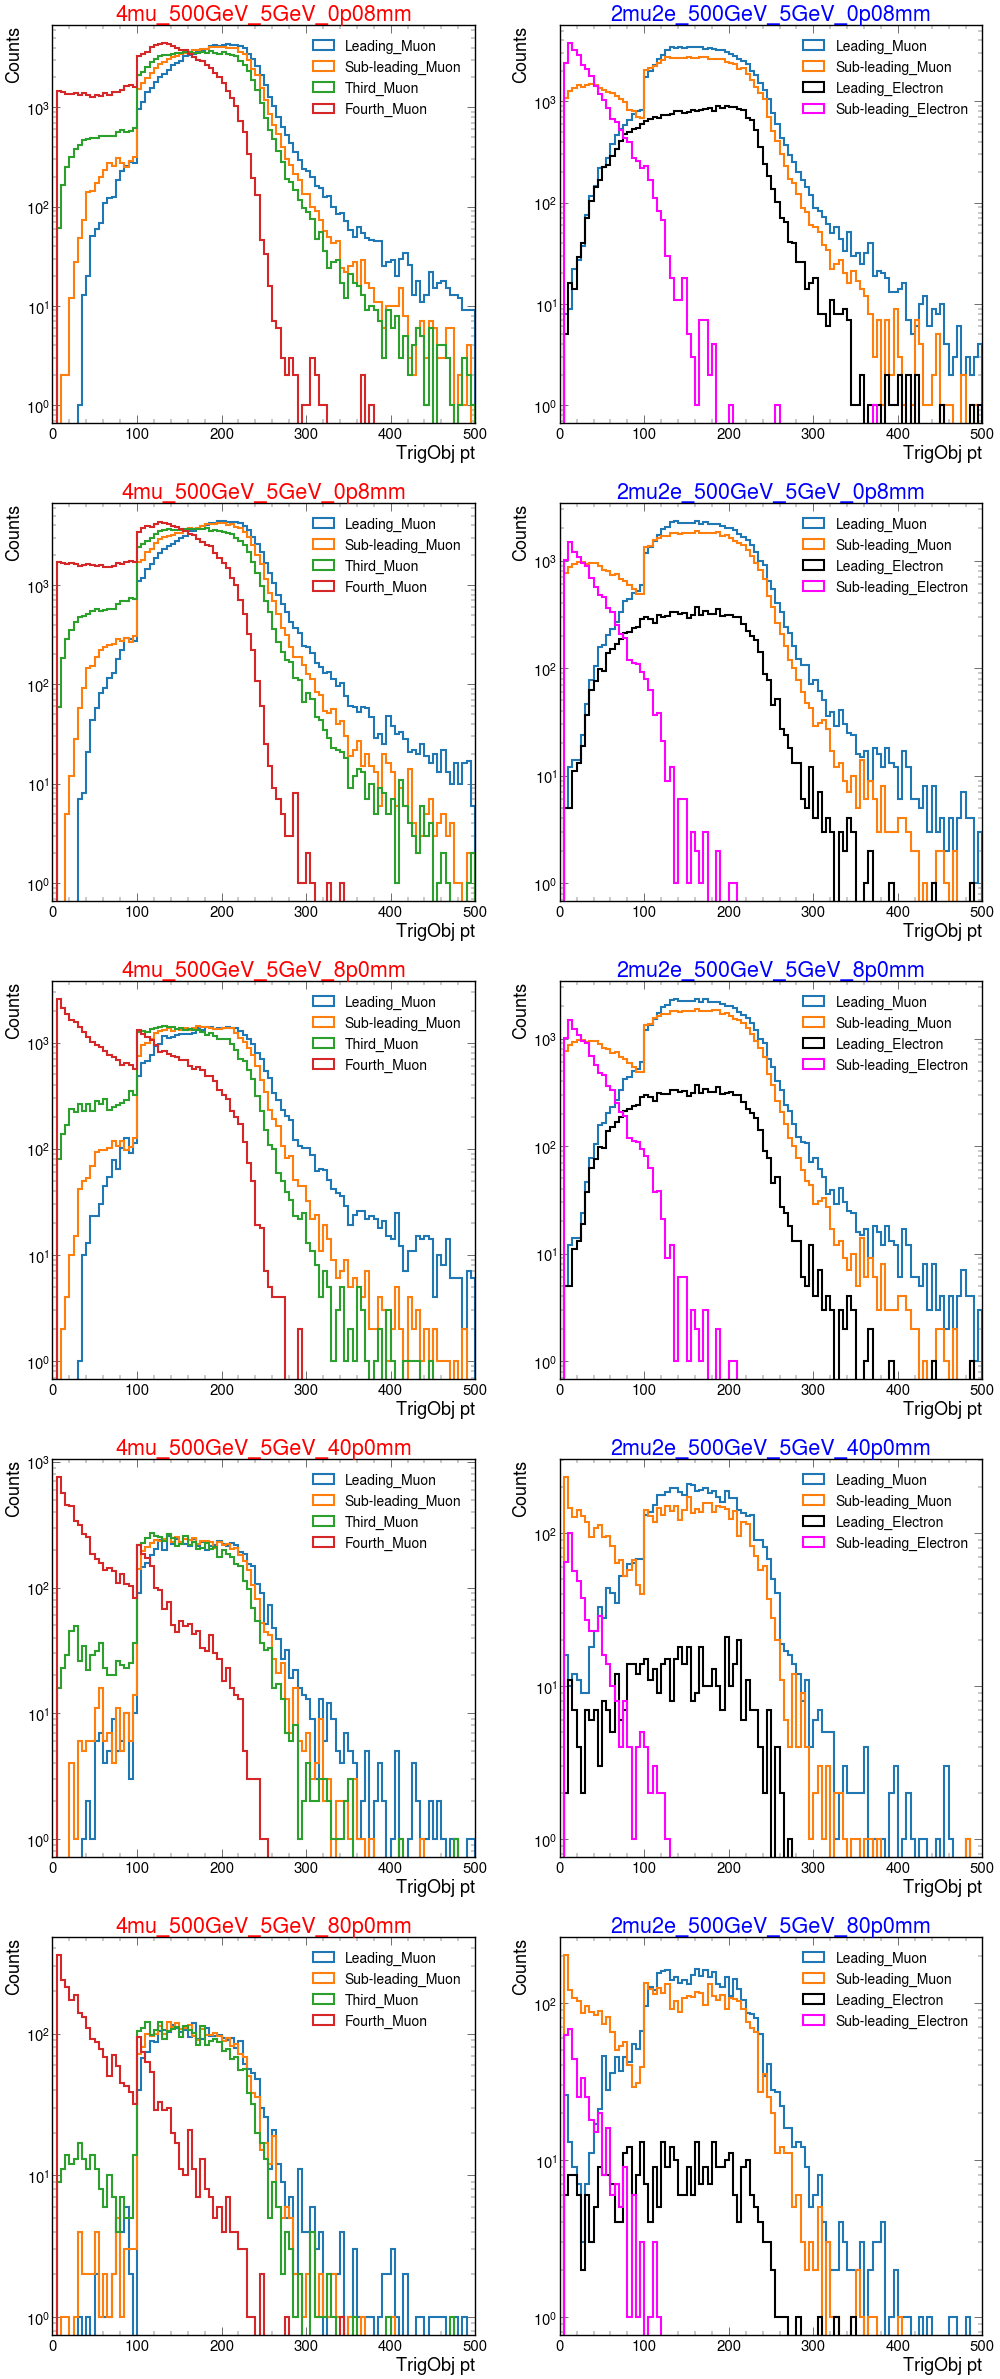

In [36]:
plt.style.use(hep.style.CMS)
fig, ax = plt.subplots(5, 2, figsize=(24,60))

plotting_4mu(fm_l_fmu1_mu['pt'], fm_sl_fmu1_mu['pt'], fm_tl_fmu1_mu['pt'], fm_fl_fmu1_mu['pt'], 0, 0, 0, 500)
plotting_2mu(l_tmu1_mu['pt'], sl_tmu1_mu['pt'], l_tmu1_ele['pt'], sl_tmu1_ele['pt'], 0, 1, 0, 500)

plotting_4mu(fm_l_fmu2_mu['pt'], fm_sl_fmu2_mu['pt'], fm_tl_fmu2_mu['pt'], fm_fl_fmu2_mu['pt'], 1, 0, 0, 500)
plotting_2mu(l_tmu2_mu['pt'], sl_tmu2_mu['pt'], l_tmu2_ele['pt'], sl_tmu2_ele['pt'], 1, 1, 0, 500)

plotting_4mu(fm_l_fmu3_mu['pt'], fm_sl_fmu3_mu['pt'], fm_tl_fmu3_mu['pt'], fm_fl_fmu3_mu['pt'], 2, 0, 0, 500)
plotting_2mu(l_tmu3_mu['pt'], sl_tmu3_mu['pt'], l_tmu3_ele['pt'], sl_tmu3_ele['pt'], 2, 1, 0, 500)

plotting_4mu(fm_l_fmu4_mu['pt'], fm_sl_fmu4_mu['pt'], fm_tl_fmu4_mu['pt'], fm_fl_fmu4_mu['pt'], 3, 0, 0, 500)
plotting_2mu(l_tmu4_mu['pt'], sl_tmu4_mu['pt'], l_tmu4_ele['pt'], sl_tmu4_ele['pt'], 3, 1, 0, 500)

plotting_4mu(fm_l_fmu5_mu['pt'], fm_sl_fmu5_mu['pt'], fm_tl_fmu5_mu['pt'], fm_fl_fmu5_mu['pt'], 4, 0, 0, 500)
plotting_2mu(l_tmu5_mu['pt'], sl_tmu5_mu['pt'], l_tmu5_ele['pt'], sl_tmu5_ele['pt'], 4, 1, 0, 500)

label('TrigObj pt')